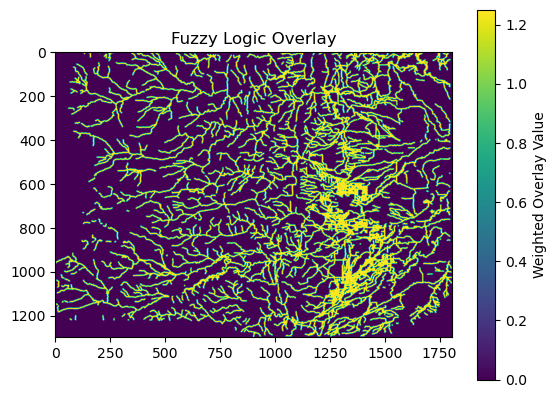

In [1]:
# overlay the following aspects to determine the best habitat for Colorado Blue Spruce in 2025 and 2050

# use soil pH
# use north aspect of terrain
# use 100m proximity to linear hydrography
# use higher precipitation climate areas
# use elevation ranges

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import CRS

# Define the UTM Zone 13N CRS (EPSG:32613)
utm_zone_13n_crs = CRS.from_epsg(32613)

# Define file names and corresponding weights
files = {
    "boulder_precipitationGFDL-ESM2G-2016-2020.tif": 0.5,
    "north_east_west_south_slopes.tif": 0.75,
    "boulder_soil_data_utm.tif": 1,
    "linearwater_buffer_utm13N100M.tif": 1.25,
    "highlighted_elevation_ranges_utm13n.tif": 1.5
}

# Initialize a variable to store the combined weighted overlay
combined_overlay = None

# Loop through the files and check the CRS and apply the weight
for file, weight in files.items():
    if os.path.exists(file):
        with rasterio.open(file) as src:
            # Check CRS
            if src.crs != utm_zone_13n_crs:
                print(f"Warning: {file} is not in UTM Zone 13N (EPSG:32613). It is in {src.crs}.")
            else:
                # Read the raster data
                data = src.read(1).astype(float)
                
                # Apply the weight
                weighted_data = data * weight
                
                # Combine the weighted data (sum all layers)
                if combined_overlay is None:
                    combined_overlay = weighted_data
                else:
                    combined_overlay += weighted_data
    else:
        print(f"File {file} not found in the current directory.")

# Check if overlay is computed
if combined_overlay is not None:
    # Plot the combined overlay
    plt.imshow(combined_overlay, cmap='viridis')
    plt.colorbar(label='Weighted Overlay Value')
    plt.title('Fuzzy Logic Overlay')
    plt.show()
else:
    print("No valid files found for the overlay.")


